In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
import cmath
import math

# Define our buildDataSet function here!

In [4]:
def buildDataSet(max_amplitude, min_sparsity, max_sparsity, vector_size, data_set_size):
    sparse_data = np.zeros((vector_size, data_set_size), dtype=float)  # Ensure float type
    
    # Iterate over the columns of the sparse_data matrix to define the data samples
    for i in range(data_set_size):
        sparsity = random.randint(min_sparsity, max_sparsity)
        indices = random.sample(range(vector_size), sparsity)
        amps = np.random.uniform(-max_amplitude, max_amplitude, sparsity)  # Use negative and positive values
        sparse_data[indices, i] = amps
    
    # Define the DFT matrix and multiply our sparse_data vectors with it to find dense data
    DFT = sp.linalg.dft(vector_size) / np.sqrt(vector_size)
    dense_data = DFT @ sparse_data
    
    return dense_data, sparse_data


## Build the dataset

In [5]:
max_amplitude = 100
min_sparsity = 10
max_sparsity = 30
vector_size = 100
data_set_size = 10000
dense_data, sparse_data = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)


## Test the dataset

In [6]:
DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
iDFT = DFT.conj().T

# Check if the iDFT of the dense data is in fact sparse
print(iDFT@dense_data)


[[ 8.48651875e-14+1.02586073e-13j -4.09563254e-14+3.12850780e-13j
  -5.79175188e+01-3.72316723e-13j ...  4.22601125e-14+1.27460224e-13j
  -5.39562054e-14-1.31733889e-13j -5.16007836e-14+8.60893686e-14j]
 [ 3.99926309e-14-6.17977928e-13j -4.88181372e+01-4.57414608e-13j
  -8.64445660e-14-7.51983077e-14j ... -4.81963495e+01-1.90713579e-13j
  -2.13162821e-13-1.54668650e-13j -1.92500458e+00-3.09619864e-13j]
 [-3.41716794e-13+3.47616384e-13j -3.64939846e-13+7.35179960e-14j
   2.69908149e-14+1.81344605e-13j ...  4.08140637e-14+4.35765451e-14j
   1.11419229e-13+1.57975644e-13j  7.50354566e-15-4.19715243e-13j]
 ...
 [ 8.15337887e-14-2.95241876e-13j  2.69978280e-14+1.68954346e-13j
   8.94184899e+01-3.85515339e-13j ...  8.23845487e-14+2.34411248e-13j
   7.47201113e-14-1.77443436e-13j -3.94445833e-13+3.62074592e-14j]
 [ 9.73448913e-14+5.88958439e-14j  7.56216501e+01-2.19690210e-13j
  -4.36276878e-13+6.80697052e-14j ... -9.50237864e-14-1.74654719e-14j
  -2.58373595e-13-1.68629815e-13j  2.63013439e-

From the above results, we can see that our vectors are very sparse if we take the IDFT

## Setting up the dataset for Pytorch

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.init as init

from sklearn.model_selection import train_test_split

print(dense_data.shape)

X = np.concatenate((dense_data.real,dense_data.imag)).T
Y = np.concatenate((dense_data.real,dense_data.imag)).T

X_tensor = torch.tensor(X,dtype=torch.float)
Y_tensor = torch.tensor(Y,dtype=torch.float)
dataset = TensorDataset(X_tensor,Y_tensor)

dataloader = DataLoader(dataset,batch_size = 500,shuffle = True, )
print(X_tensor.shape)


(100, 10000)
torch.Size([10000, 200])


## Setting up the Neural Networks

In [8]:

def complex_xavier_init(tensor_real, tensor_imag, gain=1.0):
    # Apply Xavier initialization (using uniform variant) to both real and imaginary parts
    init.xavier_uniform_(tensor_real, gain=gain)
    init.xavier_uniform_(tensor_imag, gain=gain)

class ComplexLinearUnitary(nn.Module):
    # This class serves as the encoder layer. We are restricted to values which are of the form e^jq where q are trainable parameters
    # Notice that the input and output dimensions are half of what the actual vector size is! Because it is a complex value, our dimensions are twice as long
    def __init__(self,input_dim,output_dim):
        super(ComplexLinearUnitary,self).__init__()
        # Here we create the q-values of our unitary matrix. These are the parameters we are training such that each entry of our complex matrix to encode our data is |F_ij| = 1
        self.q_values = nn.Parameter(torch.randn(output_dim,input_dim))

    def forward(self,x):   
        # Compute unitary weights dynamically in each forward pass
        W_real = torch.cos(self.q_values)
        W_imag = torch.sin(self.q_values)
        W_top = torch.cat([W_real, -W_imag], dim=1)  # [W_real, -W_imag]
        W_bottom = torch.cat([W_imag, W_real], dim=1)  # [W_imag, W_real]
        W_total = torch.cat([W_top, W_bottom], dim=0)  # Stack rows to form the full matrix 
        out = torch.matmul(x,W_total.T)
        return out
    
class ComplexLinear(nn.Module):
    # Notice that the input and output dimensions are half of what the actual vector size is! Because it is a complex value, our dimensions are twice as long. This gets fixed because we make the matrix
    # W_total which multiplies [x_real;x_imag] and returns [y_real;y_imag]
    def __init__(self,input_dim,output_dim):
        super(ComplexLinear,self).__init__()
        # Here we create the complex matrix W
        #self.W_real = nn.Parameter(torch.randn(output_dim,input_dim))# eye(input_dim))
        #self.W_imag = nn.Parameter(torch.randn(output_dim,input_dim)) #zeros((input_dim,output_dim)))

        self.W_real = nn.Parameter(torch.empty(output_dim, input_dim))
        self.W_imag = nn.Parameter(torch.empty(output_dim, input_dim))
        self.reset_parameters()
    
    def reset_parameters(self):
        # Initialize both the real and imaginary parts using Xavier initialization.
        complex_xavier_init(self.W_real, self.W_imag)
        
    def forward(self,x):   
        # Compute unitary weights dynamically in each forward pass
        W_real = self.W_real
        W_imag = self.W_imag
        W_top = torch.cat([W_real, -W_imag], dim=1)  # [W_real, -W_imag]
        W_bottom = torch.cat([W_imag, W_real], dim=1)  # [W_imag, W_real]
        W_total = torch.cat([W_top, W_bottom], dim=0)  # Stack rows to form the full matrix 
        out = torch.matmul(x,W_total.T)
        return out

class FeedthroughEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(FeedthroughEncoder, self).__init__()
        """ compression_factor = input_dim / encoding_dim
        layer_size_factor = int(encoding_dim * compression_factor / 4) """

        self.encoder = ComplexLinear(input_dim,encoding_dim)

        self.decoder = nn.Sequential(
            ComplexLinear(encoding_dim,input_dim)
        )

    def forward(self, x):
        encoder_out = self.encoder(x)
        return self.decoder(encoder_out)


class LearnedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims):
        super(LearnedAutoencoder, self).__init__()

        self.encoder = ComplexLinearUnitary(input_dim,encoding_dim)
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self, x):
        encoder_out = self.encoder(x)

        return self.decoder(encoder_out)
    
class LearnedAutoencoderWithNoise(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims,variance):
        super(LearnedAutoencoderWithNoise, self).__init__()
        self.variance = variance
        self.encoder = ComplexLinearUnitary(input_dim,encoding_dim)
        self.encoding_dim = encoding_dim
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self,x):
        encoder_out = self.encoder(x)
        noise_np = np.random.normal(0,self.variance,size=self.encoding_dim*2)
        noise = torch.tensor(noise_np,dtype=torch.float)
        noisy_y = encoder_out + noise
        return self.decoder(noisy_y)


class LearnedAutoencoderWithIQImbalance(nn.Module):
    def __init__(self, input_dim, encoding_dim,hidden_dims,b, d,variance):
        super(LearnedAutoencoderWithIQImbalance, self).__init__()
        self.encoder = ComplexLinearUnitary(input_dim,encoding_dim)
        self.encoding_dim = encoding_dim
        self.variance = variance
        self.r = torch.tensor(0.5*(1+b*np.exp(1j*d)), dtype=torch.complex64)
        layers = []
        prev_dim = encoding_dim*2
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim,dim*2))
            layers.append(nn.ReLU())
            prev_dim = dim*2
        self.decoder = nn.Sequential(
            *layers,
            nn.Linear(prev_dim,input_dim*2)
        )

    def forward(self,x):
        encoder_out = self.encoder(x)
        y_real = encoder_out[:, :self.encoding_dim]
        y_imag = encoder_out[:, self.encoding_dim:]
        y = torch.complex(y_real,y_imag)
        yiq = self.r * y + (1-self.r.conj()) * (y.conj())
        yiqr = yiq.real
        yiqi = yiq.imag
        yiqstack = torch.cat((yiqr,yiqi),dim=1)
        noise_np = np.random.normal(0,self.variance,size=self.encoding_dim*2)
        noise_tensor = torch.tensor(noise_np,dtype=torch.float)
        y_iq_stack_noisy = yiqstack + noise_tensor
        return self.decoder(y_iq_stack_noisy)


#### Training the feedthrough model

Epoch 1, Loss: 22.640352
Epoch 2, Loss: 5.450937
Epoch 3, Loss: 1.101809
Epoch 4, Loss: 0.133193
Epoch 5, Loss: 0.018465
Epoch 6, Loss: 0.002915
Epoch 7, Loss: 0.000430
Epoch 8, Loss: 0.000066
Epoch 9, Loss: 0.000011
Epoch 10, Loss: 0.000002
Epoch 11, Loss: 0.000000
Epoch 12, Loss: 0.000000
Epoch 13, Loss: 0.000000
Epoch 14, Loss: 0.000000
Epoch 15, Loss: 0.000000
Epoch 16, Loss: 0.000000
Epoch 17, Loss: 0.000000
Epoch 18, Loss: 0.000000
Epoch 19, Loss: 0.000000
Epoch 20, Loss: 0.000000


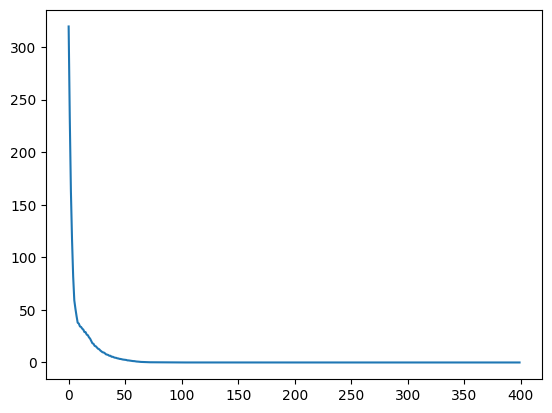

In [ ]:
# Define the size of our "measurement" vector as encoding_dim. This needs to be larger than the sparsity of our matrix

# encoding_dim = max_sparsity
# encoding_dim = 100
# vector_size = 100
encoding_dim = vector_size
# Initialize model
feedthrough_model = FeedthroughEncoder(vector_size, encoding_dim)
optimizer = torch.optim.Adam(feedthrough_model.parameters(), lr=1E-2, weight_decay=1E-6)
loss_fn = nn.MSELoss()

# def complex_mse_loss(input, target):
#     return F.mse_loss(input, target)

# Training loop
losses = []
for epoch in range(20):
    for batch in dataloader:
        inputs, targets = batch  # Unpack the tuple
        optimizer.zero_grad()
        output = feedthrough_model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

plt.plot(losses)
plt.show()


#### Train the AutoEncoder Model

Epoch 1, Loss: 336.476471
Epoch 2, Loss: 316.607788
Epoch 3, Loss: 313.782745
Epoch 4, Loss: 278.011719
Epoch 5, Loss: 238.217514
Epoch 6, Loss: 214.640793
Epoch 7, Loss: 194.585052
Epoch 8, Loss: 173.966980
Epoch 9, Loss: 166.998886
Epoch 10, Loss: 158.509674
Epoch 11, Loss: 146.333694
Epoch 12, Loss: 143.402466
Epoch 13, Loss: 136.895477
Epoch 14, Loss: 131.747787
Epoch 15, Loss: 128.227600
Epoch 16, Loss: 124.486702
Epoch 17, Loss: 118.312157
Epoch 18, Loss: 115.639587
Epoch 19, Loss: 114.100853
Epoch 20, Loss: 114.100853
Epoch 21, Loss: 107.478394
Epoch 22, Loss: 107.478394
Epoch 23, Loss: 105.620911
Epoch 24, Loss: 105.620911
Epoch 25, Loss: 104.477501
Epoch 26, Loss: 104.477501
Epoch 27, Loss: 99.675888
Epoch 28, Loss: 99.675888
Epoch 29, Loss: 99.675888
Epoch 30, Loss: 99.675888
Epoch 31, Loss: 99.675888
Epoch 32, Loss: 95.231308
Epoch 33, Loss: 93.695236
Epoch 34, Loss: 92.928757
Epoch 35, Loss: 92.612877
Epoch 36, Loss: 91.710228
Epoch 37, Loss: 91.710228
Epoch 38, Loss: 90.77

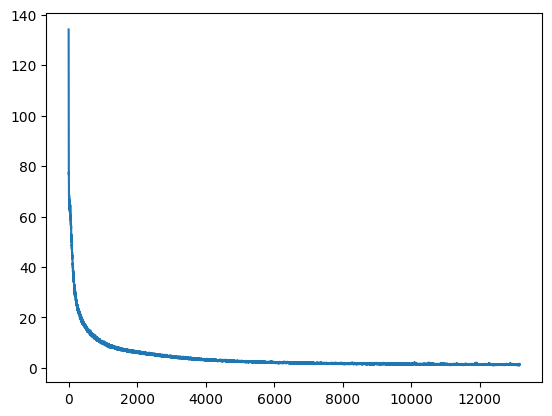

In [ ]:
# Training variables: Beta_momentum, beta_variance, learning_rate, encoding_dim, sparsity, weight_decay

# Current Iteration: 1
# Beta_momentum: 0.95
# Beta_variance: 0.99
# Learning_rate: 1E-3
# weight_decay = 0
# sparsity = 3-5

encoding_dim = 50

# Initialize model
hidden_dims = np.array([60,80])
learned_autoencoder_model = LearnedAutoencoder(vector_size,encoding_dim,hidden_dims)
optimizer = torch.optim.Adam(learned_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
loss_fn = nn.MSELoss()

# def complex_mse_loss(input, target):
#     return F.mse_loss(input, target)

# Training loop
losses = []
lowest_loss = float("inf")
for epoch in range(5000):
    for batch in dataloader:
        inputs, targets = batch  # Unpack the tuple
        optimizer.zero_grad()
        output = learned_autoencoder_model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if loss < lowest_loss:
        lowest_loss = loss.item()
        early_stopping_counter = 0
        best_model = learned_autoencoder_model
    else:
        early_stopping_counter += 1
        if early_stopping_counter > 100:
            learned_autoencoder_model = best_model
            print(f"stopped early after {epoch+1} epochs, with a loss of: {lowest_loss}")
            break

    print(f"Epoch {epoch+1}, Loss: {lowest_loss:.6f}")

plt.plot(losses)
plt.show()


Some conclusions that we have found so far:
- Batch size must be minimally greater than 100. 500 seems to work well.
- 2 hidden layers of size 50,70 leads to a loss of 0.3 MSE
- Decreasing variance below 0.999 does not seem to have a positive effect


## Train Noisy Models

In [ ]:
# Training variables: Beta_momentum, beta_variance, learning_rate, encoding_dim, sparsity, weight_decay

# Current Iteration: 1
# Beta_momentum: 0.9
# Beta_variance: 0.999
# Learning_rate: 1E-3
# weight_decay = 0
# sparsity = 3-5
# variance = 1
noisy_models = []
noisy_losses = []

# We define our signal to noise ratio as ranging from 0 to 20 dB
db_list = [2,5,8,11,14,17,20]
signal_variance = 133 # Found by measuring empirically what the variance of the signal is once transformed from sparse signal
SNR = {}

# Then define the absolute values of the SNR ratio
for db_ratio in db_list:
    SNR[db_ratio] = 10**(db_ratio/10)

for db,abs in SNR.items():
    encoding_dim = 50
    variance = signal_variance/abs
    # Initialize model
    hidden_dims = np.array([60,80])
    noisy_autoencoder_model = LearnedAutoencoderWithNoise(vector_size,encoding_dim,hidden_dims,variance)
    optimizer = torch.optim.Adam(noisy_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
    loss_fn = nn.MSELoss()
# def complex_mse_loss(input, target):
#     return F.mse_loss(input, target)
    # Training loop
    losses = []
    lowest_loss = float("inf")
    for epoch in range(1):
        for batch in dataloader:
            inputs, targets = batch  # Unpack the tuple
            optimizer.zero_grad()
            output = noisy_autoencoder_model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        if loss.item() < lowest_loss:
            lowest_loss = loss.item()
            early_stopping_counter = 0
            best_model = noisy_autoencoder_model
        else:
            early_stopping_counter += 1
            if early_stopping_counter > 100:
                noisy_autoencoder_model = best_model
                print(f"Stopped early after {epoch+1} epochs, with loss {lowest_loss:.6f}")
                break

        print(f"SNR Ratio: {db}, Epoch {epoch+1}, Loss: {loss.item():.6f}")
    noisy_models.append(best_model)
    noisy_losses.append(lowest_loss)

# plt.plot(losses)
# plt.show()(noisy_losses


SNR Ratio: 2, Epoch 1, Loss: 79.119019
SNR Ratio: 5, Epoch 1, Loss: 69.088837
SNR Ratio: 8, Epoch 1, Loss: 67.059090
SNR Ratio: 11, Epoch 1, Loss: 66.558502
SNR Ratio: 14, Epoch 1, Loss: 66.562088
SNR Ratio: 17, Epoch 1, Loss: 66.986687
SNR Ratio: 20, Epoch 1, Loss: 65.039909


TypeError: write() argument must be str, not bytes

# Save the Noisy Models

In [10]:
for indx, (db, value) in enumerate(SNR.items()):
    torch.save(noisy_models[indx].state_dict(), f"noisy_model_{db}_{min_sparsity}-{max_sparsity}.pt")


## Initialize pre-trained noiseless model

In [9]:
# Instantiate your model architecture first
encoding_dim = 50
vector_size = 100
hidden_dims = np.array([50,70])
pretrained_model = LearnedAutoencoder(vector_size,encoding_dim,hidden_dims)
# Load the state dictionary
pretrained_model.load_state_dict(torch.load("model_state_hidden_layers_50_70.pt"))

pretrained_model.eval()  # Set the model to evaluation mode if needed


LearnedAutoencoder(
  (encoder): ComplexLinearUnitary()
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=140, bias=True)
    (3): ReLU()
    (4): Linear(in_features=140, out_features=200, bias=True)
  )
)

## Show the output for a given sparse input vector



In [10]:
# Here we generate a test vector from our buildDataSet function, put it through the model and look at the output
h, x = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,1)

H = np.concatenate((h.real,h.imag)).T

H_tensor = torch.tensor(H,dtype=torch.float)

H_hat = pretrained_model(H_tensor)

h_hat = np.array(H_hat.detach())

h_real,h_imag = np.split(h_hat,2,1)
h_hat = h_real + 1j*h_imag
h_hat = h_hat.reshape(-1,1)
DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
iDFT = DFT.conj().T


x_hat = iDFT@h_hat
indices = range(len(x_hat))


/tmp/ipykernel_6464/3254949652.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  h_hat = np.array(H_hat.detach())


/home/daan/PycharmProjects/Compression/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/daan/PycharmProjects/Compression/.venv/lib/python3.12/site-packages/numpy/ma/core.py:3463: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


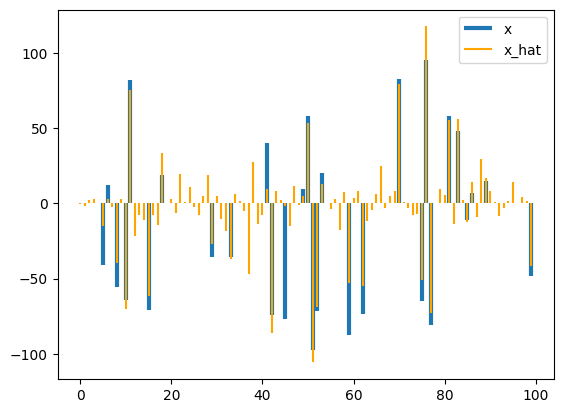

In [11]:
plt.vlines(indices,0,x,linewidth=3)
plt.vlines(indices,0,x_hat,colors="orange")

plt.legend(("x","x_hat"))


## Extract the encoding matrix, generate a (noisy) y and use the decoder to find $\hat{h}$, then plot $\hat{x}$

In [12]:
# Load the autoencoder

encoding_dim = 50
vector_size = 100
hidden_dims = np.array([60,80])
variance = 10
noisy_autoencoder = LearnedAutoencoderWithNoise(vector_size,encoding_dim,hidden_dims,variance)
noisy_autoencoder.load_state_dict(torch.load("noisy_autoencoder_10var_60_80.pt",))
noisy_autoencoder.eval()

# Build the W matrix
q_values = noisy_autoencoder_model.encoder.q_values

W_real = torch.cos(q_values)
W_imag = torch.sin(q_values)
W_top = torch.cat([W_real, -W_imag], dim=1)  # [W_real, -W_imag]
W_bottom = torch.cat([W_imag, W_real], dim=1)  # [W_imag, W_real]
W_total = torch.cat([W_top, W_bottom], dim=0)  # Stack rows to form the full matrix 

# Build the input vector

h, x = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,1)

H = np.concatenate((h.real,h.imag)).T

H_tensor = torch.tensor(H,dtype=torch.float)

y = torch.matmul(H_tensor,W_total.T)

# Make the noise

variance = 10

noise_np = np.random.normal(0,variance,size=100)
noise = torch.tensor(noise_np,dtype=torch.float)
noisy_y = y + noise

# Rebuild h, and x from the noisy y using the decoder

H_hat = noisy_autoencoder_model.decoder(noisy_y)

h_hat = np.array(H_hat.detach())

h_real,h_imag = np.split(h_hat,2,1)
h_hat = h_real + 1j*h_imag
h_hat = h_hat.reshape(-1,1)
DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
iDFT = DFT.conj().T

x_hat = iDFT@h_hat
indices = range(len(x_hat))


NameError: name 'noisy_autoencoder_model' is not defined

## Plotting

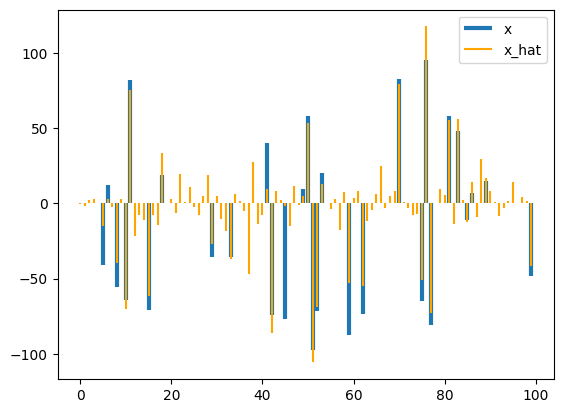

In [13]:
plt.vlines(indices,0,x,linewidth=3)
plt.vlines(indices,0,x_hat,colors="orange")

plt.legend(("x","x_hat"))


## Show the weights

In [14]:
# THIS DOESN'T WORK. TO BE FIXED

for idx, layer in enumerate(pretrained_model.decoder):
    # Check if the layer is an instance of ComplexLinear
    if isinstance(layer, nn.Linear):
        print(f"Decoder layer {idx} (ComplexLinear) W_real:")
        print(layer.weight)
        print(f"Decoder layer {idx} (ComplexLinear) W_imag:")
        print(layer.weight)


Decoder layer 0 (ComplexLinear) W_real:
Parameter containing:
tensor([[-0.0016, -0.0323,  0.1041,  ...,  0.0468, -0.0592,  0.0327],
        [-0.0235, -0.0134, -0.0171,  ...,  0.0216,  0.0314,  0.0259],
        [ 0.0065, -0.0328, -0.0397,  ..., -0.0214,  0.0142,  0.0223],
        ...,
        [ 0.0561, -0.1109,  0.1659,  ..., -0.0796, -0.3391,  0.1045],
        [-0.0328, -0.0145,  0.0484,  ..., -0.0230,  0.0081,  0.0506],
        [ 0.0097, -0.0984,  0.0116,  ...,  0.1054,  0.0210,  0.0204]],
       requires_grad=True)
Decoder layer 0 (ComplexLinear) W_imag:
Parameter containing:
tensor([[-0.0016, -0.0323,  0.1041,  ...,  0.0468, -0.0592,  0.0327],
        [-0.0235, -0.0134, -0.0171,  ...,  0.0216,  0.0314,  0.0259],
        [ 0.0065, -0.0328, -0.0397,  ..., -0.0214,  0.0142,  0.0223],
        ...,
        [ 0.0561, -0.1109,  0.1659,  ..., -0.0796, -0.3391,  0.1045],
        [-0.0328, -0.0145,  0.0484,  ..., -0.0230,  0.0081,  0.0506],
        [ 0.0097, -0.0984,  0.0116,  ...,  0.1054,  

In [15]:
imbalance_levels = [0, 0.04, 0.1, 0.3, 0.6, 1]
IRR_ratios = []
db_IRR_ratios = []

for level in imbalance_levels:
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    r = 0.5*(1+b*np.exp(1j*d))
    IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)
    IRR_ratios.append(IRR_ratio)
    print(10*np.log10(IRR_ratio))
    db_IRR_ratios.append(10*np.log10(IRR_ratio))


inf
41.08929220065852
33.118820471594574
23.531709031336195
17.42758855859956
12.849459258668094


/tmp/ipykernel_6464/4219155951.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)


In [19]:
# Looping over 
for level, db_ratio in IRR_ratios.items():
    encoding_dim = 50
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    variance = 0
    # Initialize model
    hidden_dims = np.array([60,80])
    imbalanced_autoencoder_model = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
    optimizer = torch.optim.Adam(imbalanced_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
    loss_fn = nn.MSELoss()

    # def complex_mse_loss(input, target):
    #     return F.mse_loss(input, target)

    # Training loop
    losses = []
    lowest_loss = float("inf")
    for epoch in range(10000):
        for batch in dataloader:
            inputs, targets = batch  # Unpack the tuple
            optimizer.zero_grad()
            output = imbalanced_autoencoder_model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        if loss< lowest_loss:
            lowest_loss = loss
            early_stopping_counter = 0
            best_model = imbalanced_autoencoder_model
        else:
            early_stopping_counter += 1
            if early_stopping_counter > 100:
                imbalanced_autoencoder_model = best_model
                print(f"Stopped early after {epoch+1} epochs, with loss of {lowest_loss:.6f}")
                break
        print(f"IRR Ratio:{db_ratio}, Epoch {epoch+1}, Loss: {loss.item():.6f}")
    imbalanced_models.append(best_model)
    imbalanced_losses.append(lowest_loss)

# plt.plot(losses)
# plt.show()


IRR Ratio:inf, Epoch 1, Loss: 333.789307
IRR Ratio:inf, Epoch 2, Loss: 324.582397
IRR Ratio:inf, Epoch 3, Loss: 315.376709
IRR Ratio:inf, Epoch 4, Loss: 295.905518
IRR Ratio:inf, Epoch 5, Loss: 259.772217
IRR Ratio:inf, Epoch 6, Loss: 238.346878
IRR Ratio:inf, Epoch 7, Loss: 207.468964
IRR Ratio:inf, Epoch 8, Loss: 188.123123
IRR Ratio:inf, Epoch 9, Loss: 177.880417
IRR Ratio:inf, Epoch 10, Loss: 170.624084
IRR Ratio:inf, Epoch 11, Loss: 162.864227
IRR Ratio:inf, Epoch 12, Loss: 144.542007
IRR Ratio:inf, Epoch 13, Loss: 141.888626
IRR Ratio:inf, Epoch 14, Loss: 136.097641
IRR Ratio:inf, Epoch 15, Loss: 135.182953
IRR Ratio:inf, Epoch 16, Loss: 126.540977
IRR Ratio:inf, Epoch 17, Loss: 126.511642
IRR Ratio:inf, Epoch 18, Loss: 123.623062
IRR Ratio:inf, Epoch 19, Loss: 117.018600
IRR Ratio:inf, Epoch 20, Loss: 117.539337
IRR Ratio:inf, Epoch 21, Loss: 114.677063
IRR Ratio:inf, Epoch 22, Loss: 109.889717
IRR Ratio:inf, Epoch 23, Loss: 109.506264
IRR Ratio:inf, Epoch 24, Loss: 107.553062
I

# Train the IQ Imbalance model

In [16]:

imbalance_levels = [0, 0.04, 0.1, 0.3, 0.6, 1]
IRR_ratios = {}

# Calculate the dB imbalance levels, we store them in the dictionary IRR_ratios such that we can extract it with the corresponding level imbalance
for level in imbalance_levels:
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    r = 0.5*(1+b*np.exp(1j*d))
    IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)
    IRR_ratios[level] = 10*np.log10(IRR_ratio)


/tmp/ipykernel_6464/2421521896.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)


# Save the IQ-Imbalance Models


In [17]:
for indx, items in enumerate(IRR_ratios):
    torch.save(imbalanced_models[indx].state_dict(), f"imbalanced_model_{items:.3f}_{min_sparsity}-{max_sparsity}.pt")


NameError: name 'imbalanced_models' is not defined

# Train various measurement matrix size

In [21]:
measurement_sizes = [5, 10, 20, 30, 40, 50]
measurement_models = []
measurement_losses = []

for encoding_dim in measurement_sizes:
    level = 0.6 # Set the IQ imbalance level to around 33 dB IRR
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    variance = signal_variance/SNR[17] # Set the SNR to 17 dB
    # Initialize model
    hidden_dims = np.array([60,80])
    measurement_autoencoder_model = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
    optimizer = torch.optim.Adam(measurement_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
    loss_fn = nn.MSELoss()

    # def complex_mse_loss(input, target):
    #     return F.mse_loss(input, target)

    # Training loop
    losses = []
    lowest_loss = float("inf")
    for epoch in range(10000):
        for batch in dataloader:
            inputs, targets = batch  # Unpack the tuple
            optimizer.zero_grad()
            output = measurement_autoencoder_model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        if loss< lowest_loss:
            lowest_loss = loss
            early_stopping_counter = 0
            best_model = measurement_autoencoder_model
        else:
            early_stopping_counter += 1
            if early_stopping_counter > 100:
                measurement_autoencoder_model = best_model
                print(f"Stopped early after {epoch+1} epochs, with loss of {lowest_loss:.6f}")
                break
        print(f"Encoding dimension:{encoding_dim}, Epoch {epoch+1}, Loss: {loss.item():.6f}")
    measurement_models.append(best_model)
    measurement_losses.append(lowest_loss)


Encoding dimension:5, Epoch 1, Loss: 342.898163
Encoding dimension:5, Epoch 2, Loss: 333.303131
Encoding dimension:5, Epoch 3, Loss: 321.463318
Encoding dimension:5, Epoch 4, Loss: 313.634186
Encoding dimension:5, Epoch 5, Loss: 316.763824
Encoding dimension:5, Epoch 6, Loss: 298.046387
Encoding dimension:5, Epoch 7, Loss: 298.433838
Encoding dimension:5, Epoch 8, Loss: 302.387177
Encoding dimension:5, Epoch 9, Loss: 299.592865
Encoding dimension:5, Epoch 10, Loss: 311.491364
Encoding dimension:5, Epoch 11, Loss: 290.830841
Encoding dimension:5, Epoch 12, Loss: 305.597961
Encoding dimension:5, Epoch 13, Loss: 296.979828
Encoding dimension:5, Epoch 14, Loss: 298.581024
Encoding dimension:5, Epoch 15, Loss: 300.025391
Encoding dimension:5, Epoch 16, Loss: 297.160828
Encoding dimension:5, Epoch 17, Loss: 293.307190
Encoding dimension:5, Epoch 18, Loss: 293.762665
Encoding dimension:5, Epoch 19, Loss: 304.820251
Encoding dimension:5, Epoch 20, Loss: 305.238037
Encoding dimension:5, Epoch 2

# Save the measurement models

In [18]:
measurement_sizes = [5, 10, 20, 30, 40, 50]
for indx, encoding_dim in enumerate(measurement_sizes):
    torch.save(measurement_models[indx].state_dict(), f"measurement_model_{encoding_dim}_{min_sparsity}-{max_sparsity}.pt")


NameError: name 'measurement_models' is not defined

# Plotting

In [19]:
plt.rcParams['text.usetex'] = False
SNRkeys = SNR.keys()
plt.plot(SNRkeys, noisy_losses)
plt.title("Noisy Autoencoder Loss vs SNR")
plt.xlabel("SNR")
plt.ylabel("RMSE")
plt.show()


NameError: name 'noisy_losses' is not defined

In [20]:
imbalanced_losses_np = []
for loss in imbalanced_losses:
    imbalanced_losses_np.append(torch.Tensor.detach(loss))

db_IRR_ratios = []

for level in imbalance_levels:
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    r = 0.5*(1+b*np.exp(1j*d))
    IRR_ratio = (np.abs(r)**2)/(np.abs(1-r)**2)
    IRR_ratios[level] = 10*np.log10(IRR_ratio)
    db_IRR_ratios.append(10*np.log10(IRR_ratio))

print(db_IRR_ratios)
print(imbalanced_losses_np)
print(len(db_IRR_ratios))
plt.figure()
plt.plot(db_IRR_ratios, imbalanced_losses_np)
plt.title("Imbalanced Autoencoder")
plt.xlabel("IRR Ratio ($dB$)")
plt.ylabel("RMSE Loss")
plt.show()


NameError: name 'imbalanced_losses' is not defined

In [21]:
# Test IQ Imbalance model

# Generate a vector
h, x = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,1)

H = np.concatenate((h.real,h.imag)).T


H_tensor = torch.tensor(H,dtype=torch.float)

imbalanced_autoencoder_model(H_tensor)


NameError: name 'imbalanced_autoencoder_model' is not defined

# Generate new dataset, initialize pretrained models, evaluate the loss and plot

In [22]:
noisy_pretrained_models = {}
imbalanced_pretrained_models = {}
measurement_pretrained_models = {}

# Define the SNR dictionary for use
db_list = [2,5,8,11,14,17,20]
signal_variance = 133 # Found by measuring empirically what the variance of the signal is once transformed from sparse signal
SNR = {}

# Then define the absolute values of the SNR ratio
for db_ratio in db_list:
    SNR[db_ratio] = 10**(db_ratio/10)

#Initialize pretrained noisy models
for db,abs in SNR.items():
    encoding_dim = 50
    variance = signal_variance/abs
    # Initialize model
    hidden_dims = np.array([60,80])
    noisy_pretrained_models[db] = LearnedAutoencoderWithNoise(vector_size,encoding_dim,hidden_dims,variance)
    noisy_pretrained_models[db].load_state_dict(torch.load(f"noisy_model_{db}.pt", weights_only=True))

# Initialize pretrained imbalanced models
for level, db  in IRR_ratios.items():
    encoding_dim = 50
    variance = 0
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    # Initialize model
    hidden_dims = np.array([60,80])
    imbalanced_pretrained_models[level] = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
    imbalanced_pretrained_models[level].load_state_dict(torch.load(f"imbalanced_model_{db:.3f}.pt", weights_only=True))

# Initialize pretrained imbalanced models
for encoding_dim  in measurement_sizes:
    variance = signal_variance/SNR[17]
    level = 0.6
    b = 1 - (0.2 * level)
    d = level * np.pi/8
    # Initialize model
    hidden_dims = np.array([60,80])
    measurement_pretrained_models[encoding_dim] = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
    measurement_pretrained_models[encoding_dim].load_state_dict(torch.load(f"measurement_model_{encoding_dim}.pt", weights_only=True))


In [23]:
# Generate dataset
max_amplitude = 100
min_sparsity = 3
max_sparsity = 5
vector_size = 100
data_set_size = 10000
val_dense_data, val_sparse_data = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)

print(val_sparse_data[0,:])

X_val = np.concatenate((val_dense_data.real,val_dense_data.imag)).T
Y_val = np.concatenate((val_dense_data.real,val_dense_data.imag)).T

X_val_tensor = torch.tensor(X_val,dtype=torch.float)
Y_val_tensor = torch.tensor(Y_val,dtype=torch.float)
val_dataset = TensorDataset(X_val_tensor,Y_val_tensor)

dataloader_val = DataLoader(val_dataset,batch_size = 500,shuffle = True, )

loss_fn = nn.MSELoss()


[ 0.          0.          0.         ... 80.14727006  0.
  0.        ]


In [24]:

# Validating the noisy models
noisy_val_losses = []
noisy_model_losses = []

with torch.no_grad():
    for db, noisy_model in noisy_pretrained_models.items():
        noisy_model.eval()
        for batch in dataloader_val:
            inputs, targets = batch  # Unpack the tuple
            output = noisy_model(inputs)
            loss = loss_fn(output, targets)
            noisy_model_losses.append(loss.item())
        noisy_val_losses.append(np.average(noisy_model_losses))
        noisy_model_losses = []

noisy_val_losses = np.array(noisy_val_losses)
normalized_noisy_val_losses = noisy_val_losses/signal_variance
print(noisy_val_losses)


[32.6548707  16.55186024  4.48329661  5.18890345  4.12244819  3.77935289
  3.49532073]


In [25]:
# Validating the IQ imbalance models
imbalance_model_losses = []
imbalance_val_losses = []

with torch.no_grad():
    for level, imbalance_model in imbalanced_pretrained_models.items():
        imbalance_model.eval()
        for batch in dataloader_val:
            inputs, targets = batch  # Unpack the tuple
            output = noisy_model(inputs)
            loss = loss_fn(output, targets)
            imbalance_model_losses.append(loss.item())
        imbalance_val_losses.append(np.average(imbalance_model_losses))
        imbalance_model_losses = []

imbalance_val_losses = np.array(imbalance_val_losses)
normalized_imbalance_val_losses = imbalance_val_losses/signal_variance
print(imbalance_val_losses)


[3.52568058 3.49990845 3.49393191 3.50475924 3.52320414 3.49918604]


In [26]:
# Validating the varying measurement dimensions models
measurement_model_losses = []
measurement_val_losses = []

with torch.no_grad():
    for encoding_dim, measurement_model in measurement_pretrained_models.items():
        measurement_model.eval()
        for batch in dataloader_val:
            inputs, targets = batch  # Unpack the tuple
            output = measurement_model(inputs)
            loss = loss_fn(output, targets)
            measurement_model_losses.append(loss.item())
        measurement_val_losses.append(np.average(measurement_model_losses))
        print(f"Encoding dimenson:{encoding_dim} Losses:{measurement_model_losses}")
        measurement_model_losses = []

measurement_val_losses = np.array(measurement_val_losses)
normalized_measurement_val_losses = measurement_val_losses/signal_variance


Encoding dimenson:5 Losses:[49.52234649658203, 47.31100845336914, 48.678340911865234, 48.23323440551758, 48.15464401245117, 49.377071380615234, 51.669288635253906, 50.6449089050293, 46.502723693847656, 49.398895263671875, 49.15474319458008, 50.59788131713867, 49.99372863769531, 49.46232604980469, 45.170536041259766, 50.23191833496094, 50.22827911376953, 49.072750091552734, 51.273529052734375, 48.76128005981445]
Encoding dimenson:10 Losses:[38.88037109375, 37.50940704345703, 34.282535552978516, 39.259281158447266, 38.41685104370117, 36.67747497558594, 37.420188903808594, 36.03688049316406, 39.57445526123047, 35.5384635925293, 38.80818176269531, 36.0785026550293, 37.372825622558594, 36.16999053955078, 37.7635612487793, 38.52311325073242, 37.012123107910156, 37.80504608154297, 36.83034896850586, 38.980491638183594]
Encoding dimenson:20 Losses:[18.03469467163086, 18.855667114257812, 18.01930809020996, 18.256540298461914, 17.549421310424805, 15.960762023925781, 17.969104766845703, 17.061044

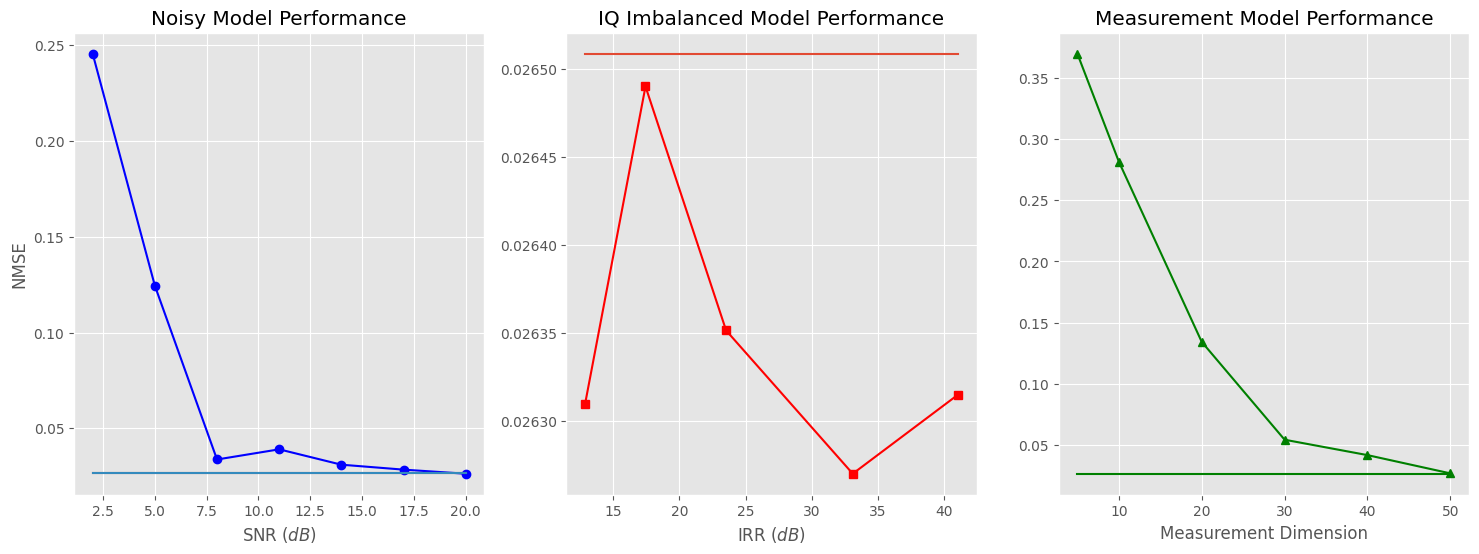

In [27]:
noiseless_loss = normalized_imbalance_val_losses[0]

plt.style.use('ggplot')
fig1, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows = 1,figsize=(18, 6))
ax1.plot(SNR.keys(),normalized_noisy_val_losses,color= "blue", marker="o")
ax1.plot(SNR.keys(), [noiseless_loss for i in SNR.keys()])
ax1.set_xlabel("SNR $(dB)$")
ax1.set_ylabel("NMSE")
ax1.set_title("Noisy Model Performance")
ax1.grid(True)

ax2.plot(IRR_ratios.values(),normalized_imbalance_val_losses,color= 'red',marker='s')
ax2.plot(IRR_ratios.values(), [noiseless_loss for i in IRR_ratios.values()])
ax2.set_xlabel("IRR $(dB)$")
ax2.set_title("IQ Imbalanced Model Performance")

ax1.plot(SNR.keys(), [noiseless_loss for i in SNR.keys()])
ax2.grid(True)

ax3.plot(measurement_sizes,normalized_measurement_val_losses,color= 'green',marker='^')
ax3.plot(measurement_sizes, [noiseless_loss for i in measurement_sizes], color='green')
ax3.set_xlabel("Measurement Dimension")
ax3.set_title("Measurement Model Performance")
ax3.grid(True)


## Create a new loss function to drive the values of the measurement matrix to discrete values $\{-\pi,-\frac{1}{2}\pi,0,\frac{1}{2}\pi,\pi\}$

In [28]:
def discreteLossPoly(qweights,scaleFactor):
    loss = 0
    pi = torch.tensor(math.pi)
    # Note that we need to flatten the weights so that our iteration does not result in us iterating over the rows instead of the weights
    qVec = qweights.flatten()
    # Efficient implementation of the loss function, by doing vector operations, saves a lot of time in training
    loss += torch.linalg.vector_norm(qVec*(qVec-1/2*pi)*(qVec-1*pi)*(qVec+pi)*(qVec+1/2*pi),1)
    loss = loss*scaleFactor # Scale the resulting loss
    return loss

In [29]:
sparsity_ranges = [(3, 5), (5, 7), (7, 9), (10, 30)]

# Define the SNR dictionary for use
db_list = [2,5,8,11,14,17,20]
signal_variance = 133 # Found by measuring empirically what the variance of the signal is once transformed from sparse signal
SNR = {}

# Then define the absolute values of the SNR ratio
for db_ratio in db_list:
    SNR[db_ratio] = 10**(db_ratio/10)

#empty dicts to store models in
noisy_pretrained_models = {}
imbalanced_pretrained_models = {}
measurement_pretrained_models = {}

for i, (min_spars, max_spars) in enumerate(sparsity_ranges):

    #Initialize pretrained noisy models
    for db,abs in SNR.items():
        encoding_dim = 50
        variance = signal_variance/abs
        # Initialize model
        hidden_dims = np.array([60,80])
        noisy_pretrained_models[(i, db)] = LearnedAutoencoderWithNoise(vector_size,encoding_dim,hidden_dims,variance)
        noisy_pretrained_models[(i, db)].load_state_dict(torch.load(f"noisy_model_{db}_{min_spars}-{max_spars}.pt", weights_only=True))

    # Initialize pretrained imbalanced models
    for level, db  in IRR_ratios.items():
        encoding_dim = 50
        variance = 0
        b = 1 - (0.2 * level)
        d = level * np.pi/8
        # Initialize model
        hidden_dims = np.array([60,80])
        imbalanced_pretrained_models[(i, level)] = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
        imbalanced_pretrained_models[(i, level)].load_state_dict(torch.load(f"imbalanced_model_{level:.3f}_{min_spars}-{max_spars}.pt", weights_only=True))

    # Initialize pretrained measurement models
    for encoding_dim  in measurement_sizes:
        variance = signal_variance/SNR[17]
        level = 0.6
        b = 1 - (0.2 * level)
        d = level * np.pi/8
        # Initialize model
        hidden_dims = np.array([60,80])
        measurement_pretrained_models[(i, encoding_dim)] = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
        measurement_pretrained_models[(i, encoding_dim)].load_state_dict(torch.load(f"measurement_model_{encoding_dim}_{min_spars}-{max_spars}.pt", weights_only=True))




In [30]:

# Generate dataset
def Generate_Dataloader(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size):
    for i, (min_spars, max_spars) in enumerate(sparsity_ranges):
        val_dense_data, val_sparse_data = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,data_set_size)

        X_val = np.concatenate((val_dense_data.real,val_dense_data.imag)).T
        Y_val = np.concatenate((val_dense_data.real,val_dense_data.imag)).T

        X_val_tensor = torch.tensor(X_val,dtype=torch.float)
        Y_val_tensor = torch.tensor(Y_val,dtype=torch.float)
        val_dataset = TensorDataset(X_val_tensor,Y_val_tensor)

        dataloader_val = DataLoader(val_dataset,batch_size = 500,shuffle = True, )
        variance = np.var(Y_val)
    return dataloader_val, variance



In [31]:

all_noisy_losses = []
all_imbalanced_losses = []
all_measurement_losses = []


for min_spars, max_spars in sparsity_ranges:
    dataloader_val, signal_variance = Generate_Dataloader(max_amplitude, min_spars, max_spars, vector_size, data_set_size)
    # Evaluate noisy models
    noisy_val_losses = []
    noisy_model_losses = []
    with torch.no_grad():
        for db, abs in SNR.items():
            noisy_model = noisy_pretrained_models[(i, db)]
            noisy_model.eval()
            for batch in dataloader_val:
                inputs, targets = batch  # Unpack the tuple
                output = noisy_model(inputs)
                loss = loss_fn(output, targets)
                noisy_model_losses.append(loss.item())
            noisy_val_losses.append(np.average(noisy_model_losses))
            noisy_model_losses = []

    noisy_val_losses = np.array(noisy_val_losses)
    normalized_noisy_val_losses = noisy_val_losses/signal_variance
    all_noisy_losses.append(normalized_noisy_val_losses)

    # Evaluate Imbalanced models
    imbalance_model_losses = []
    imbalance_val_losses = []

    with torch.no_grad():
        for level, db in IRR_ratios.items():
            imbalance_model = imbalanced_pretrained_models[(i, level)]
            imbalance_model.eval()
            for batch in dataloader_val:
                inputs, targets = batch  # Unpack the tuple
                output = noisy_model(inputs)
                loss = loss_fn(output, targets)
                imbalance_model_losses.append(loss.item())
            imbalance_val_losses.append(np.average(imbalance_model_losses))
            imbalance_model_losses = []

    imbalance_val_losses = np.array(imbalance_val_losses)
    normalized_imbalance_val_losses = imbalance_val_losses/signal_variance
    all_imbalanced_losses.append(normalized_imbalance_val_losses)

    # Evaluate models with varying measurement sizes
    measurement_model_losses = []
    measurement_val_losses = []

    with (torch.no_grad()):
        for encoding_dim in measurement_sizes:
            mesaurement_model = measurement_pretrained_models[(i, encoding_dim)]
            measurement_model.eval()
            for batch in dataloader_val:
                inputs, targets = batch  # Unpack the tuple
                output = measurement_model(inputs)
                loss = loss_fn(output, targets)
                measurement_model_losses.append(loss.item())
            measurement_val_losses.append(np.average(measurement_model_losses))
            measurement_model_losses = []

    measurement_val_losses = np.array(measurement_val_losses)
    normalized_measurement_val_losses = measurement_val_losses#/signal_variance
    all_measurement_losses.append(normalized_measurement_val_losses)



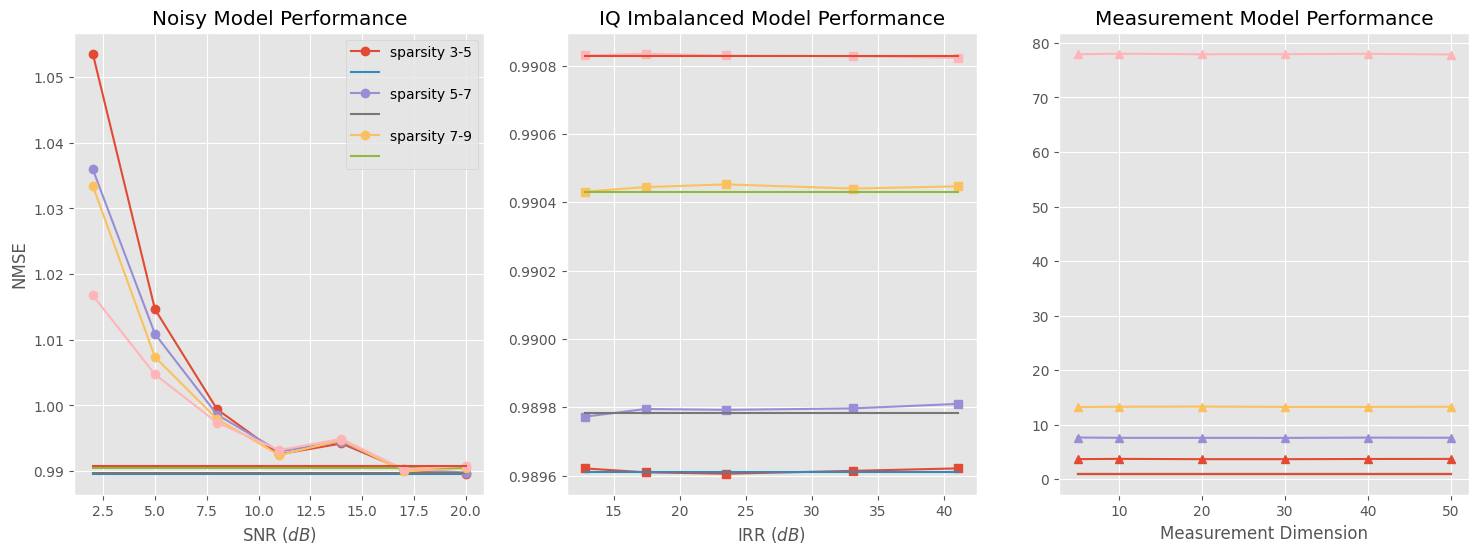

In [32]:
plt.style.use('ggplot')
fig1, (ax1, ax2, ax3) = plt.subplots(ncols=3,nrows = 1,figsize=(18, 6))

for i in range(4):
    noiseless_loss = all_imbalanced_losses[i][0]

    ax1.plot(SNR.keys(), all_noisy_losses[i], marker="o")
    ax1.plot(SNR.keys(), [noiseless_loss for i in SNR.keys()])
    ax1.set_xlabel("SNR $(dB)$")
    ax1.set_ylabel("NMSE")
    ax1.set_title("Noisy Model Performance")
    ax1.grid(True)
    ax1.legend(["sparsity 3-5","", "sparsity 5-7","", "sparsity 7-9",""])

    ax2.plot(IRR_ratios.values(),all_imbalanced_losses[i],marker='s')
    ax2.plot(IRR_ratios.values(), [noiseless_loss for i in IRR_ratios.values()])
    ax2.set_xlabel("IRR $(dB)$")
    ax2.set_title("IQ Imbalanced Model Performance")
    ax1.legend(["sparsity 3-5","", "sparsity 5-7","", "sparsity 7-9",""])
    ax2.grid(True)

    ax3.plot(measurement_sizes, all_measurement_losses[i],marker='^')
    ax3.plot(measurement_sizes, [noiseless_loss for i in measurement_sizes])
    ax3.set_xlabel("Measurement Dimension")
    ax3.set_title("Measurement Model Performance")
    ax1.legend(["sparsity 3-5","", "sparsity 5-7","", "sparsity 7-9",""])
    ax3.grid(True)



## Train neural network using new loss function

In [ ]:
vector_size = 100
encoding_dim = 50
hidden_dims = np.array([60,80])
discrete_autoencoder_model = LearnedAutoencoder(vector_size,encoding_dim,hidden_dims)
optimizer = torch.optim.Adam(discrete_autoencoder_model.parameters(), lr=1E-3, betas=(0.9,0.999))
MSELossfn = nn.MSELoss()
scaleFactor = 0.05 # Hyperparameter, setting this too high causes the problem to not converge to low loss, due to the problem converging to discrete values too early, setting too low causes the
# values to not converge to discrete values. Empirical testing showed that scaleFactor of 0.05 was nice

# Training loop
losses = []
lowest_loss = float("inf")
for epoch in range(5000):
    for batch in dataloader:
        inputs, targets = batch  # Unpack the tuple
        optimizer.zero_grad()
        output = discrete_autoencoder_model(inputs)
        qweights = discrete_autoencoder_model.encoder.q_values
        loss = discreteLossPoly(qweights,scaleFactor) + MSELossfn(output,targets)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if loss < lowest_loss:
        lowest_loss = loss.item()
        early_stopping_counter = 0
        best_model = discrete_autoencoder_model
    else:
        early_stopping_counter += 1
        if early_stopping_counter > 100:
            discrete_autoencoder_model = best_model
            print(f"stopped early after {epoch+1} epochs, with a loss of: {lowest_loss}")
            break

    print(f"Epoch {epoch+1}, Loss: {lowest_loss:.6f}")

plt.plot(losses)
plt.show()

Epoch 1, Loss: 2645.344971
Epoch 2, Loss: 2547.080566
Epoch 3, Loss: 2427.472168
Epoch 4, Loss: 2300.237061
Epoch 5, Loss: 2163.362305
Epoch 6, Loss: 2033.887451
Epoch 7, Loss: 1918.541382
Epoch 8, Loss: 1789.123169
Epoch 9, Loss: 1671.917236
Epoch 10, Loss: 1554.813599
Epoch 11, Loss: 1434.463013
Epoch 12, Loss: 1326.812988
Epoch 13, Loss: 1214.382690
Epoch 14, Loss: 1103.209229
Epoch 15, Loss: 996.980469
Epoch 16, Loss: 895.793457
Epoch 17, Loss: 795.651062
Epoch 18, Loss: 703.884460
Epoch 19, Loss: 609.846619
Epoch 20, Loss: 527.907166
Epoch 21, Loss: 451.424927
Epoch 22, Loss: 378.636841
Epoch 23, Loss: 329.233551
Epoch 24, Loss: 286.206543


## Show the values of the weights, they should be $\{0,\pm1.57079,\pm3.14159\}$

In [58]:
print(discrete_autoencoder_model.encoder.q_values[0:20,0:20])
discreteLossPoly(X_tensor[0,:],X_tensor[0,:],qweights,MSELossfn,scaleFactor)

tensor([[-1.9066e-04, -1.5710e+00,  1.7653e-05,  5.7156e-06,  1.5708e+00,
         -1.5706e+00, -1.5709e+00,  1.5709e+00, -1.5709e+00, -2.2890e-05,
         -5.9371e-05, -1.5708e+00, -1.5710e+00, -1.5707e+00, -2.2502e-04,
          1.7860e-05,  2.3317e-05,  2.8789e-05,  7.5287e-05, -8.8234e-05],
        [-3.7344e-05,  6.9782e-05,  1.5707e+00, -2.7430e-05, -1.5707e+00,
          1.5709e+00, -7.7168e-06,  1.5707e+00,  4.3897e-06,  1.4019e-04,
          2.6552e-04, -1.4161e-04, -1.5707e+00, -7.6120e-05,  1.4672e-04,
         -5.6015e-05,  2.9536e-05, -6.8375e-05, -9.7270e-05, -1.2646e-05],
        [ 7.9465e-05, -1.5705e+00, -5.1330e-06,  3.5685e-07, -1.1624e-04,
          1.5708e+00,  1.5706e+00,  9.3457e-05, -1.5710e+00,  1.9962e-04,
         -3.3353e-05,  1.5708e+00, -1.5706e+00, -1.5710e+00, -6.2822e-05,
          3.4599e-05, -2.4821e-05,  1.5708e+00, -8.6485e-05,  1.6953e-04],
        [-3.9986e-05,  1.0941e-04,  8.7162e-05, -5.0042e-05,  1.5708e+00,
          1.7541e-05,  1.5708e+00, 

tensor(0.7825, grad_fn=<AddBackward0>)

## Now we map all the values to actual discrete values

In [98]:
def mapToDiscreteValues(weights,discrete_values):
    # Input is a tensor (possibly a matrix) of weights, and a np array of discrete values
    discrete_values = discrete_values.flatten()
    weights_np = weights.detach().cpu().numpy() # Convert to numpy array
    shape = weights_np.shape
    weights_vector = np.reshape(weights_np,(-1,1)) # flatten the matrix to a vector such that subtracting from the discrete values results in a matrix!
    
    # Create a matrix of distances, then make a vector of indices from this matrix. Each value of the vector is the index of the closest discrete value
    distances = np.abs(weights_vector - discrete_values)
    indices = np.argmin(distances,1)

    # Map the weights to the closest discrete values and reshape into original matrix, and turn into a nn.Parameter object
    mappedWeights = discrete_values[indices]
    mappedWeights = np.reshape(mappedWeights,shape)
    mappedWeights = np.float32(mappedWeights) # Notice we map it to a float because that is what is used for our model
    mappedWeights = nn.Parameter(torch.from_numpy(mappedWeights))
    return mappedWeights

# Testing

qweights = discrete_autoencoder_model.encoder.q_values
discrete_values = np.array([-np.pi, -0.5*np.pi,0,0.5*np.pi,np.pi])
mapped_q_weights = mapToDiscreteValues(qweights,discrete_values)


mapped_discrete_autoencoder_model = discrete_autoencoder_model
mapped_discrete_autoencoder_model.encoder.q_values = mapped_q_weights


## Save the model

In [99]:
torch.save(mapped_discrete_autoencoder_model.state_dict(), f"discrete_model.pt")

## Load discrete model

In [100]:
discrete_model = LearnedAutoencoder(vector_size,encoding_dim,hidden_dims)
# Load the state dictionary
discrete_model.load_state_dict(torch.load("discrete_model.pt"))

C:\Users\tomli\AppData\Local\Temp\ipykernel_21884\2779864902.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  discrete_model.load_state_dict(torch.load("discrete_model.pt

<All keys matched successfully>

## Finally we test on a single data point and map the result!

c:\Users\tomli\anaconda3\envs\pytorch_311\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\tomli\anaconda3\envs\pytorch_311\Lib\site-packages\numpy\ma\core.py:3413: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


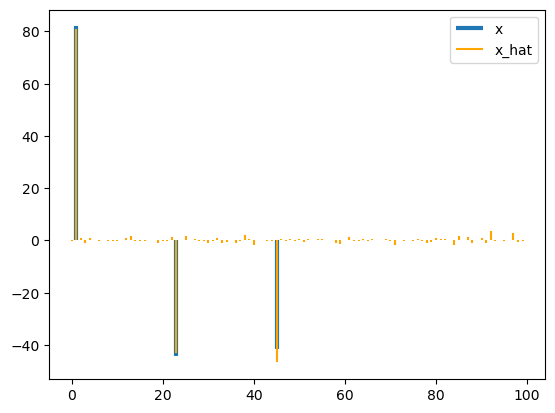

In [101]:
# Here we generate a test vector from our buildDataSet function, put it through the model and look at the output
h, x = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,1)

H = np.concatenate((h.real,h.imag)).T

H_tensor = torch.tensor(H,dtype=torch.float)

H_hat = discrete_model(H_tensor)

h_hat = np.array(H_hat.detach())

h_real,h_imag = np.split(h_hat,2,1)
h_hat = h_real + 1j*h_imag
h_hat = h_hat.reshape(-1,1)
DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
iDFT = DFT.conj().T


x_hat = iDFT@h_hat
indices = range(len(x_hat))

plt.vlines(indices,0,x,linewidth=3)
plt.vlines(indices,0,x_hat,colors="orange")

plt.legend(("x","x_hat"))

## And then we test on the validation data set!

In [102]:
discrete_model_losses = []
with torch.no_grad():
    discrete_model.eval()
    for batch in dataloader_val:
        inputs, targets = batch  # Unpack the tuple
        output = discrete_model(inputs)
        loss = loss_fn(output, targets)
        discrete_model_losses.append(loss.item())
    discrete_loss = np.average(discrete_model_losses)
signal_variance = 133
normalized_discrete_val_loss = discrete_loss/signal_variance
print(normalized_discrete_val_loss)

0.020008922698802518


## Code works, so we train the model for worst case scenarios for SNR, IRR and encoding dim. We take the two worst for each case

In [ ]:
def trainModelsForDiscreteSet(dataloader,SNR_values,imb_percentages,encoding_dims,signal_variance = 133,hidden_dims=[60,80],scale_factor=0.05):
    # Function takes as inputs:
    # dataloader: The dataloader object of the training data set
    # SNR_values: Signal to noise ratios
    # imb_percentages: imbalance percentages
    # encoding_dims: Encoding dimensions
    # signal_variance: The variance of the original signal
    # hidden_dims: Hidden dimensions for the neural network
    # scale_factor: Hyperparameter for the discretization step
    models = []
    discrete_values = np.array([-np.pi, -0.5*np.pi,0,0.5*np.pi,np.pi])
    for model_num,(SNR,imb_percentage,encoding_dim) in enumerate(zip(SNR_values,imb_percentages,encoding_dims)):
        abs_noise_ratio = 10**(SNR/10)
        variance = signal_variance/abs_noise_ratio
        b = 1 - (0.2 * imb_percentage)
        d = imb_percentage * np.pi/8
        hidden_dims = np.array([60,80])
        current_training_model = LearnedAutoencoderWithIQImbalance(vector_size,encoding_dim,hidden_dims,b,d,variance)
        optimizer = torch.optim.Adam(current_training_model.parameters(), lr=1E-3, betas=(0.9,0.999))
        MSEloss_fn = nn.MSELoss()

        # Training loop
        losses = []
        lowest_loss = float("inf")
        for epoch in range(10000):
            for batch in dataloader:
                inputs, targets = batch  # Unpack the tuple
                optimizer.zero_grad()
                output = current_training_model(inputs)
                qweights = current_training_model.encoder.q_values
                loss = discreteLossPoly(qweights,scale_factor) + MSEloss_fn(output, targets)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            if loss< lowest_loss:
                lowest_loss = loss
                early_stopping_counter = 0
                best_model = current_training_model
            else:
                early_stopping_counter += 1
                if early_stopping_counter > 100:
                    current_training_model = best_model
                    print(f"Stopped early after {epoch+1} epochs, with loss of {lowest_loss:.6f}")
                    break
            print(f"SNR:{SNR},Imbalance Percentag:{imb_percentage}, Encoding dimension:{encoding_dim}, Epoch {epoch+1}, Loss: {loss.item():.6f}")
        best_qvalues = best_model.encoder.q_values
        mapped_best_qvalues = mapToDiscreteValues(best_qvalues,discrete_values)
        best_model.encoder.q_values = mapped_best_qvalues
        models.append(best_model)
        losses.append(lowest_loss)
    return models

def validateModels(dataloader,models,signal_variance=133):
    models_losses = []

    with torch.no_grad():
        for model in models:
            current_model_losses = []
            model.eval()
            for batch in dataloader:
                inputs, targets = batch  # Unpack the tuple
                output = model(inputs)
                loss = loss_fn(output, targets)
                current_model_losses.append(loss.item())
            models_losses.append(np.average(current_model_losses))

    models_losses = np.array(models_losses)
    normalized_models_losses = models_losses/signal_variance
    return normalized_models_losses,models_losses

def visualizeReconstruction(model,max_amplitude=100,min_sparsity=3,max_sparsity=5,vector_size=100):
    h, x = buildDataSet(max_amplitude,min_sparsity,max_sparsity,vector_size,1)

    H = np.concatenate((h.real,h.imag)).T

    H_tensor = torch.tensor(H,dtype=torch.float)

    H_hat = model(H_tensor)

    h_hat = np.array(H_hat.detach())

    h_real,h_imag = np.split(h_hat,2,1)
    h_hat = h_real + 1j*h_imag
    h_hat = h_hat.reshape(-1,1)
    DFT = sp.linalg.dft(vector_size)/np.sqrt(vector_size)
    iDFT = DFT.conj().T


    x_hat = iDFT@h_hat
    indices = range(len(x_hat))

    plt.vlines(indices,0,x,linewidth=3)
    plt.vlines(indices,0,x_hat,colors="orange")

    plt.legend(("x","x_hat"))

In [135]:
# We train six models
SNR_list = [5, 2.5, np.inf, np.inf, np.inf, np.inf]
imb_percentage_list = [0, 0, 0.6, 1, 0, 0]
encoding_dims_list = [50, 50, 50, 50, 10, 5]

discrete_models = trainModelsForDiscreteSet(dataloader,SNR_list,imb_percentage_list,encoding_dims_list,scale_factor=0.01)


Encoding dimension:50, Epoch 1, Loss: 532.051270
Encoding dimension:50, Epoch 2, Loss: 513.415039
Encoding dimension:50, Epoch 3, Loss: 489.000732
Encoding dimension:50, Epoch 4, Loss: 468.732544
Encoding dimension:50, Epoch 5, Loss: 451.798737
Encoding dimension:50, Epoch 6, Loss: 427.810394
Encoding dimension:50, Epoch 7, Loss: 403.699554
Encoding dimension:50, Epoch 8, Loss: 378.096222
Encoding dimension:50, Epoch 9, Loss: 357.761353
Encoding dimension:50, Epoch 10, Loss: 335.470459
Encoding dimension:50, Epoch 11, Loss: 311.368317
Encoding dimension:50, Epoch 12, Loss: 286.297974
Encoding dimension:50, Epoch 13, Loss: 264.802063
Encoding dimension:50, Epoch 14, Loss: 243.435638
Encoding dimension:50, Epoch 15, Loss: 223.056946
Encoding dimension:50, Epoch 16, Loss: 201.755585
Encoding dimension:50, Epoch 17, Loss: 182.293640
Encoding dimension:50, Epoch 18, Loss: 160.524017
Encoding dimension:50, Epoch 19, Loss: 144.829407
Encoding dimension:50, Epoch 20, Loss: 129.552673
Encoding 

(array([0.20249235, 0.31251078, 0.01426226, 0.01446308, 0.3280743 ,
       0.46699781]), array([26.9314827 , 41.56393375,  1.89688094,  1.92358898, 43.63388176,
       62.11070919]))


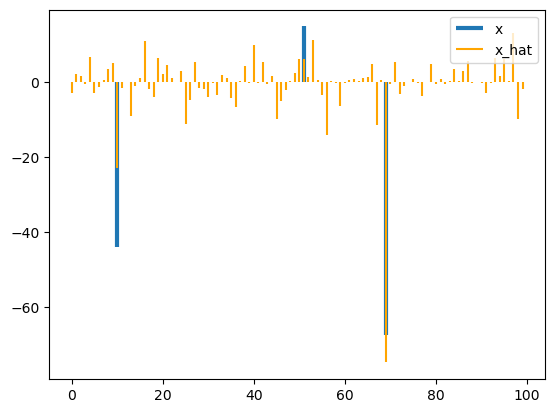

In [138]:

normalized_losses = validateModels(dataloader_val,discrete_models)
print(normalized_losses)

visualizeReconstruction(discrete_models[0])